## Classifying Flowers using Transfer Learning in Keras

1- Download a small flower dataset (http://download.tensorflow.org/example_images/flower_photos.tgz). This dataset has 5 classes (Daisy, Dandelion, Rese, Sunflower, and Tulip). Images for each class are stored in its own folder.

2- The images have different dimensions. Resize all of them to 150x150.

3- Split images to 75-25% for training and test. Make sure you have the same distribution of flower types between train and test datasets. 

4- Use a VGG16 model (pre-trained on ImageNet)

5- Remove the top layers (fully connected layers)

6- Add your own fully connected layers (one with 256 nodes using ‘relu’ activation and output layer with 5 nodes and ‘softmax’ activation)

7- First, freeze all layers of VGG16, train (fine-tune) and evaluate the model. You need to pick the right hyper-parameters for your training (try with different ones)

8- Second, unfreeze the last block of VGG16 (block5), re-train and evaluate the model

9- Unfreeze all the layers and try again. 

10- Compare the accuracy you got in both cases . Which one is better and why?

## Setup

In [1]:
# if True, will download the pictures
# set to True only the first time you are running this notebook
download_pictures = True


In [2]:
from keras import optimizers
from keras.callbacks import EarlyStopping

image_w, image_h = 150, 150
batch_size = 20
epochs = 10
loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
optimizer = optimizers.SGD(lr=0.0001, momentum=0.9)
es = EarlyStopping(monitor='accuracy', mode='min', verbose=1)
weights = "imagenet"
disable_early_stopping = True
callbacks=[es]
if disable_early_stopping:
    callbacks=[]


Using TensorFlow backend.


In [3]:
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
from setups import *
from plotting import *
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

In [4]:
# Trainable layers
def printTrainableLayers(model):
    for i, layer in enumerate(model.layers):
        print(i, layer.name, layer.trainable)

In [5]:
def printAccuracy(score):
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

## Data Preparation

In [6]:
import urllib.request
import tarfile

local_filename = 'flower_photos.tgz'

# download the pictures depending on the flag
if download_pictures:
    local_filename, headers = urllib.request.urlretrieve('http://download.tensorflow.org/example_images/flower_photos.tgz',
                                                    filename=local_filename)
    print(headers)
    tar = tarfile.open(local_filename, "r:gz")
    tar.extractall(path=".")
    tar.close()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "flower_photos"

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(image_w, image_h),
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='training')

test_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(image_w, image_h),
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='validation')


Found 2755 images belonging to 5 classes.
Found 915 images belonging to 5 classes.


In [8]:
from tensorflow.keras.preprocessing import image

def printImage(generator):
    for data_batch, labels_batch in train_generator:
        plt.figure(0)
        imgplot = plt.imshow(image.array_to_img(data_batch[0]))
        print('Data batch shape:', data_batch.shape)
        print('Labels batch shape:', labels_batch.shape)
        break

Training data
Data batch shape: (20, 150, 150, 3)
Labels batch shape: (20,)


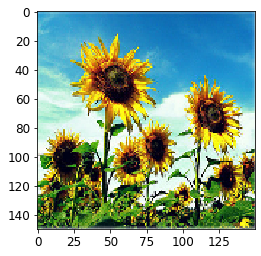

In [9]:
print('Training data')
printImage(train_generator)

Testing data
Data batch shape: (20, 150, 150, 3)
Labels batch shape: (20,)


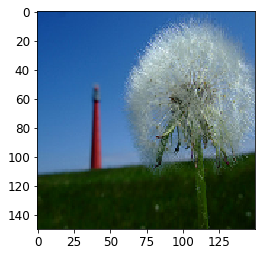

In [10]:
print('Testing data')
printImage(test_generator)


## Model1

### Hyperparameters Set 1

applications.VGG16.pooling=None

optimizers.SGD(lr=0.0001, momentum=0.9)

In [11]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
model1 = applications.VGG16(weights = weights, include_top=False, input_shape = (image_w, image_h, 3))
# Freezing all layers
for layer in model1.layers:
    layer.trainable = False
printTrainableLayers(model1)
model1.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0   

In [12]:
# Adding custom layers to create a new model 
new_model1 = Sequential([
    model1,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')
])
new_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
new_predictions (Dense)      (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 2,098,693
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
# Compiling the model
new_model1.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# training
new_model1.fit_generator(train_generator,epochs=epochs,verbose=1, callbacks=callbacks)
score1 = new_model1.evaluate(test_generator, verbose=1)
printAccuracy(score1)

Epoch 1/10
138/138 [==============================] - 248s 2s/step - loss: 1.4574 - accuracy: 0.4062
Epoch 2/10
138/138 [==============================] - 256s 2s/step - loss: 1.1309 - accuracy: 0.6174
Epoch 3/10
138/138 [==============================] - 260s 2s/step - loss: 0.9761 - accuracy: 0.6751
Epoch 4/10
138/138 [==============================] - 251s 2s/step - loss: 0.8831 - accuracy: 0.7078
Epoch 5/10
138/138 [==============================] - 258s 2s/step - loss: 0.8187 - accuracy: 0.7267
Epoch 6/10
138/138 [==============================] - 267s 2s/step - loss: 0.7658 - accuracy: 0.7503
Epoch 7/10
138/138 [==============================] - 264s 2s/step - loss: 0.7317 - accuracy: 0.7597
Epoch 8/10
138/138 [==============================] - 261s 2s/step - loss: 0.6983 - accuracy: 0.7757
Epoch 9/10
138/138 [==============================] - 263s 2s/step - loss: 0.6688 - accuracy: 0.7808
Epoch 10/10
46/46 [==============================] - 84s 2s/step
Test loss: 0.9433407187461

### Hyperparameters Set 2

applications.VGG16.pooling='avg'

optimizers.SGD(lr=0.0001, momentum=0.9)

In [14]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
model1_hp2 = applications.VGG16(weights = weights, include_top=False, input_shape = (image_w, image_h, 3), pooling='avg')
# Freezing all layers
for layer in model1_hp2.layers:
    layer.trainable = False
printTrainableLayers(model1_hp2)
model1_hp2.summary()

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 global_average_pooling2d_1 False
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling

In [15]:
# Adding custom layers to create a new model 
new_model1_hp2 = Sequential([
    model1_hp2,
    #Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')
])
new_model1_hp2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               131328    
_________________________________________________________________
new_predictions (Dense)      (None, 5)                 1285      
Total params: 14,847,301
Trainable params: 132,613
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
# Compiling the model
new_model1_hp2.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# training
new_model1_hp2.fit_generator(train_generator,epochs=epochs,verbose=1, callbacks=callbacks)
score1_hp2 = new_model1.evaluate(test_generator, verbose=1)
printAccuracy(score1_hp2)

Epoch 1/10
138/138 [==============================] - 269s 2s/step - loss: 1.6163 - accuracy: 0.2258
Epoch 2/10
138/138 [==============================] - 261s 2s/step - loss: 1.5448 - accuracy: 0.3216
Epoch 3/10
138/138 [==============================] - 255s 2s/step - loss: 1.4997 - accuracy: 0.3840
Epoch 4/10
138/138 [==============================] - 257s 2s/step - loss: 1.4602 - accuracy: 0.4421
Epoch 5/10
138/138 [==============================] - 260s 2s/step - loss: 1.4259 - accuracy: 0.4584
Epoch 6/10
138/138 [==============================] - 265s 2s/step - loss: 1.3942 - accuracy: 0.5034
Epoch 7/10
138/138 [==============================] - 267s 2s/step - loss: 1.3641 - accuracy: 0.5314
Epoch 8/10
138/138 [==============================] - 262s 2s/step - loss: 1.3339 - accuracy: 0.5408
Epoch 9/10
138/138 [==============================] - 267s 2s/step - loss: 1.3080 - accuracy: 0.5713
Epoch 10/10
46/46 [==============================] - 88s 2s/step
Test loss: 1.1222989559173

### Hyperparameters Set 3

applications.VGG16.pooling='max'

optimizers.SGD(lr=0.0001, momentum=0.9)

In [17]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
model1_hp3 = applications.VGG16(weights = weights, include_top=False, input_shape = (image_w, image_h, 3), pooling='max')
# Freezing all layers
for layer in model1_hp3.layers:
    layer.trainable = False
printTrainableLayers(model1_hp3)
model1_hp3.summary()

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 global_max_pooling2d_1 False
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D) 

In [18]:
# Adding custom layers to create a new model 
new_model1_hp3 = Sequential([
    model1_hp3,
    #Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')
])
new_model1_hp3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               131328    
_________________________________________________________________
new_predictions (Dense)      (None, 5)                 1285      
Total params: 14,847,301
Trainable params: 132,613
Non-trainable params: 14,714,688
_________________________________________________________________


In [19]:
# Compiling the model
new_model1_hp3.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# training
new_model1_hp3.fit_generator(train_generator,epochs=epochs,verbose=1, callbacks=callbacks)
score1_hp3 = new_model1.evaluate(test_generator, verbose=1)
printAccuracy(score1_hp3)

Epoch 1/10
138/138 [==============================] - 263s 2s/step - loss: 1.6122 - accuracy: 0.2461
Epoch 2/10
138/138 [==============================] - 259s 2s/step - loss: 1.4219 - accuracy: 0.4279
Epoch 3/10
138/138 [==============================] - 259s 2s/step - loss: 1.2948 - accuracy: 0.5314
Epoch 4/10
138/138 [==============================] - 266s 2s/step - loss: 1.2010 - accuracy: 0.5880
Epoch 5/10
138/138 [==============================] - 278s 2s/step - loss: 1.1297 - accuracy: 0.6218
Epoch 6/10
138/138 [==============================] - 261s 2s/step - loss: 1.0724 - accuracy: 0.6490
Epoch 7/10
138/138 [==============================] - 262s 2s/step - loss: 1.0275 - accuracy: 0.6595
Epoch 8/10
138/138 [==============================] - 260s 2s/step - loss: 0.9903 - accuracy: 0.6704
Epoch 9/10
138/138 [==============================] - 260s 2s/step - loss: 0.9562 - accuracy: 0.6806
Epoch 10/10
46/46 [==============================] - 86s 2s/step
Test loss: 0.5061442852020

### Hyperparameters Set 4

applications.VGG16.pooling=None

optimizers.SGD(lr=0.01, momentum=0.9)

In [20]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
model1_hp4 = applications.VGG16(weights = weights, include_top=False, input_shape = (image_w, image_h, 3))
# Freezing all layers
for layer in model1_hp4.layers:
    layer.trainable = False
printTrainableLayers(model1_hp4)
model1_hp4.summary()

0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0   

In [21]:
# Adding custom layers to create a new model 
new_model1_hp4 = Sequential([
    model1_hp4,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')
])
new_model1_hp4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
new_predictions (Dense)      (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 2,098,693
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:
# Compiling the model
new_model1_hp4.compile(loss=loss, optimizer=optimizers.SGD(lr=0.01, momentum=0.9), metrics=metrics)

# training
new_model1_hp4.fit_generator(train_generator,epochs=epochs,verbose=1, callbacks=callbacks)
score1_hp4 = new_model1.evaluate(test_generator, verbose=1)
printAccuracy(score1_hp4)

Epoch 1/10
138/138 [==============================] - 276s 2s/step - loss: 1.4400 - accuracy: 0.4142
Epoch 2/10
138/138 [==============================] - 266s 2s/step - loss: 0.9717 - accuracy: 0.6261
Epoch 3/10
138/138 [==============================] - 265s 2s/step - loss: 0.9366 - accuracy: 0.6490
Epoch 4/10
138/138 [==============================] - 263s 2s/step - loss: 0.8685 - accuracy: 0.6871
Epoch 5/10
138/138 [==============================] - 260s 2s/step - loss: 0.6781 - accuracy: 0.7691
Epoch 6/10
138/138 [==============================] - 262s 2s/step - loss: 0.7141 - accuracy: 0.7481
Epoch 7/10
138/138 [==============================] - 261s 2s/step - loss: 0.6636 - accuracy: 0.7757
Epoch 8/10
138/138 [==============================] - 273s 2s/step - loss: 0.5197 - accuracy: 0.8316
Epoch 9/10
138/138 [==============================] - 269s 2s/step - loss: 0.5277 - accuracy: 0.8207
Epoch 10/10
46/46 [==============================] - 86s 2s/step
Test loss: 0.8389815092086

### Hyperparameters Set 5

applications.VGG16.pooling=None

optimizers.SGD(lr=0.0001, momentum=0.45)

In [23]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
model1_hp5 = applications.VGG16(weights = weights, include_top=False, input_shape = (image_w, image_h, 3))
# Freezing all layers
for layer in model1_hp5.layers:
    layer.trainable = False
printTrainableLayers(model1_hp5)
model1_hp5.summary()

0 input_5 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0   

In [24]:
# Adding custom layers to create a new model 
new_model1_hp5 = Sequential([
    model1_hp5,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')
])
new_model1_hp5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
new_predictions (Dense)      (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 2,098,693
Non-trainable params: 14,714,688
_________________________________________________________________


In [25]:
# Compiling the model
new_model1_hp5.compile(loss=loss, optimizer=optimizers.SGD(lr=0.0001, momentum=0.45), metrics=metrics)

# training
new_model1_hp5.fit_generator(train_generator,epochs=epochs,verbose=1, callbacks=callbacks)
score1_hp5 = new_model1.evaluate(test_generator, verbose=1)
printAccuracy(score1_hp5)

Epoch 1/10
138/138 [==============================] - 263s 2s/step - loss: 1.6036 - accuracy: 0.2588
Epoch 2/10
138/138 [==============================] - 262s 2s/step - loss: 1.4774 - accuracy: 0.3848
Epoch 3/10
138/138 [==============================] - 260s 2s/step - loss: 1.3842 - accuracy: 0.4711
Epoch 4/10
138/138 [==============================] - 259s 2s/step - loss: 1.3099 - accuracy: 0.5209
Epoch 5/10
138/138 [==============================] - 266s 2s/step - loss: 1.2484 - accuracy: 0.5673
Epoch 6/10
138/138 [==============================] - 261s 2s/step - loss: 1.1951 - accuracy: 0.5949
Epoch 7/10
138/138 [==============================] - 267s 2s/step - loss: 1.1512 - accuracy: 0.6189
Epoch 8/10
138/138 [==============================] - 259s 2s/step - loss: 1.1114 - accuracy: 0.6381
Epoch 9/10
138/138 [==============================] - 261s 2s/step - loss: 1.0772 - accuracy: 0.6512
Epoch 10/10
46/46 [==============================] - 90s 2s/step
Test loss: 0.5991205573081

## Model2

In [26]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
model2 = applications.VGG16(weights = weights, include_top=False, input_shape = (image_w, image_h, 3))
# Freezing the layers until block5
for layer in model2.layers[:15]:
    layer.trainable = False
printTrainableLayers(model2)
model2.summary()

0 input_6 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0       

In [27]:
# Adding custom layers to create a new model 
new_model2 = Sequential([
    model2,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')
])
new_model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
new_predictions (Dense)      (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 9,178,117
Non-trainable params: 7,635,264
_________________________________________________________________


In [28]:
# Compiling the model
new_model2.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# training
new_model2.fit_generator(train_generator,epochs=epochs,verbose=1, callbacks=callbacks)
score2 = new_model2.evaluate(test_generator, verbose=1)
printAccuracy(score2)

Epoch 1/10
138/138 [==============================] - 354s 3s/step - loss: 1.2695 - accuracy: 0.5056
Epoch 2/10
138/138 [==============================] - 320s 2s/step - loss: 0.7286 - accuracy: 0.7365
Epoch 3/10
138/138 [==============================] - 320s 2s/step - loss: 0.5411 - accuracy: 0.8087
Epoch 4/10
138/138 [==============================] - 320s 2s/step - loss: 0.4391 - accuracy: 0.8523
Epoch 5/10
138/138 [==============================] - 326s 2s/step - loss: 0.3558 - accuracy: 0.8842
Epoch 6/10
138/138 [==============================] - 319s 2s/step - loss: 0.2978 - accuracy: 0.9053
Epoch 7/10
138/138 [==============================] - 323s 2s/step - loss: 0.2515 - accuracy: 0.9216
Epoch 8/10
138/138 [==============================] - 318s 2s/step - loss: 0.2176 - accuracy: 0.9405
Epoch 9/10
138/138 [==============================] - 319s 2s/step - loss: 0.1828 - accuracy: 0.9495
Epoch 10/10
46/46 [==============================] - 85s 2s/step
Test loss: 1.1478068828582

## Model3

In [29]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
model3 = applications.VGG16(weights = weights, include_top=False, input_shape = (image_w, image_h, 3))
# all layers will be trainable
printTrainableLayers(model3)
model3.summary()

0 input_7 False
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
___________

In [30]:
# Adding custom layers to create a new model 
new_model3 = Sequential([
    model3,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')
])
new_model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
new_predictions (Dense)      (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 16,813,381
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Compiling the model
new_model3.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# training
new_model3.fit_generator(train_generator,epochs=epochs,verbose=1, callbacks=callbacks)
score3 = new_model3.evaluate(test_generator, verbose=1)
printAccuracy(score3)

Epoch 1/10
138/138 [==============================] - 982s 7s/step - loss: 1.2055 - accuracy: 0.5303
Epoch 2/10
138/138 [==============================] - 974s 7s/step - loss: 0.5658 - accuracy: 0.7971
Epoch 3/10
138/138 [==============================] - 957s 7s/step - loss: 0.3775 - accuracy: 0.8610
Epoch 4/10
138/138 [==============================] - 968s 7s/step - loss: 0.2499 - accuracy: 0.9162
Epoch 5/10
138/138 [==============================] - 988s 7s/step - loss: 0.1774 - accuracy: 0.9372
Epoch 6/10
138/138 [==============================] - 962s 7s/step - loss: 0.1184 - accuracy: 0.9648
Epoch 7/10
138/138 [==============================] - 959s 7s/step - loss: 0.0632 - accuracy: 0.9837
Epoch 8/10
138/138 [==============================] - 958s 7s/step - loss: 0.0412 - accuracy: 0.9917
Epoch 9/10
138/138 [==============================] - 948s 7s/step - loss: 0.0160 - accuracy: 0.9996
Epoch 10/10
46/46 [==============================] - 88s 2s/step
Test loss: 1.2802140712738

## Outcome Comparison

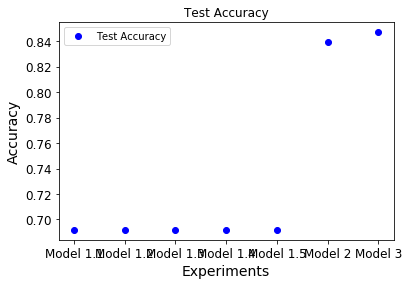

In [32]:
experiments = ["Model 1.1","Model 1.2","Model 1.3","Model 1.4","Model 1.5","Model 2","Model 3"]

test_acc_summary = []

test_acc_summary.append(score1[1])
test_acc_summary.append(score1_hp2[1])
test_acc_summary.append(score1_hp3[1])
test_acc_summary.append(score1_hp4[1])
test_acc_summary.append(score1_hp5[1])
test_acc_summary.append(score2[1])
test_acc_summary.append(score3[1])

# "bo" is for "blue dot"
plt.plot(experiments, test_acc_summary, 'bo', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Experiments')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
    

The better model is Model 3, because params are all trainable. This way the convolutional layers could learn the specifics of flowers data set.